In [46]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import random
import os
import hashlib
import requests
import re
import collections
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython import display

## 门控记忆元

## 从零开始实现

In [47]:
## 初始化模型参数
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )
    W_xi, W_hi, b_i = three()   ## 输入门参数
    W_xf, W_hf, b_f = three()   ## 遗忘门参数
    W_xo, W_ho, b_o = three()   ## 输出门参数
    W_xc, W_hc, b_c = three()   ## 候选记忆门参数
    ## 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    ## 附加梯度
    params = [W_xi, W_hi, b_i,
              W_xf, W_hf, b_f,
              W_xo, W_ho, b_o,
              W_xc, W_hc, b_c,
              W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [48]:
## 定义模型
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))
def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    H, C = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X@W_xi) + (H@W_hi) + b_i)
        F = torch.sigmoid((X@W_xf) + (H@W_hf) + b_f)
        O = torch.sigmoid((X@W_xo) + (H@W_ho) + b_o)
        C_tilda = torch.sigmoid((X@W_xc) + (H@W_hc) + b_c)
        C = F*C + I*C_tilda
        H = O * torch.tanh(C)
        Y = (H@W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [49]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [50]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [51]:
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [52]:
def read_time_machine():
    with open(download_dataset('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [53]:
def tokenize(lines, token='word'):
    match token:
        case 'word':
            return [line.split() for line in lines]
        case 'char':
            return [list(line) for line in lines]
        case _:
            print('错误: 未知词元类型: '+token)

In [54]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = [] if tokens is None else tokens
        reserved_tokens = [] if reserved_tokens is None else reserved_tokens
        ## 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx2token = ['<unk>'] + reserved_tokens
        self.token2idx = {token: idx for idx, token in enumerate(self.idx2token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token2idx:
                self.idx2token.append(token)
                self.token2idx[token] = len(self.idx2token)-1
    def __len__(self):
        return len(self.idx2token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token2idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx2token[indices]
        return [self.idx2token[index] for index in indices]
    @property
    def unk(self):
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs 
    @staticmethod
    def count_corpus(tokens):
        """统计词元频率"""
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
  

In [55]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [56]:
## 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    corpus = corpus[random.randint(0, num_steps-1):]
    num_subseqs = (len(corpus)-1) // num_steps
    initial_indices = list(range(0, num_subseqs*num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size*num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [57]:
## 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus)-offset-1)//batch_size)*batch_size
    Xs = torch.tensor(corpus[offset:offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+num_tokens+1])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps*num_batches, num_steps):
        X = Xs[:, i:i+num_steps]
        Y = Ys[:, i:i+num_steps]
        yield X, Y

In [58]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        self.data_iter_fn = seq_data_iter_random if use_random_iter else seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)  
        self.batch_size, self.num_steps = batch_size, num_steps
    def  __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [59]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens
    )
    return data_iter, data_iter.vocab

In [60]:
batch_size, num_steps  = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [61]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [62]:
def predict(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1, 1)
    ## 预热期
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    ## 预测num_preds步
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx2token[i] for i in outputs])

In [63]:
def grad_clipping_scratch(net, theta):
    """裁剪梯度"""
    params = net.params
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad *= theta/norm

In [64]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.cumsum(self.times).tolist()

In [65]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [66]:
def train_epoch_scratch(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, Timer()
    metric = Accumulator(2)  ## 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            for s in state:
                s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        l.backward()
        grad_clipping_scratch(net, 1)
        updater(batch_size=1)    
        metric.add(l*y.numel(), y.numel())
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()


In [67]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [68]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [69]:
def train_scratch(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict_ = lambda prefix: predict(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_scratch(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch+1) % 10 == 0:
            print(predict_('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict_('time traveller'))
    print(predict_('traveller'))

困惑度 4.5, 14527.6 词元/秒 cpu
time traveller thing the time traveller thing the time traveller
travellered the time traveller thing the time traveller thi


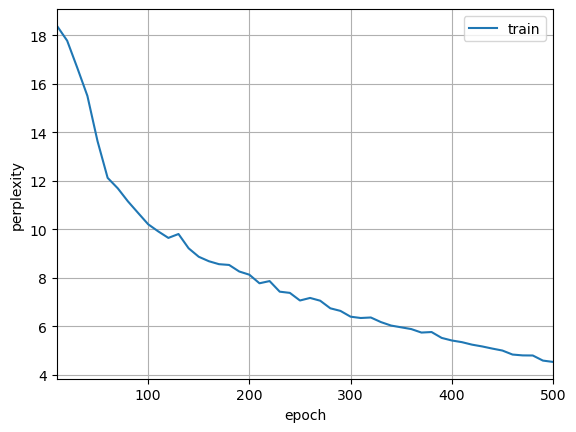

In [72]:
vocab_size, num_hiddens, device = len(vocab), 256, torch.device('cpu')
num_epochs, lr = 500, 5
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
train_scratch(model, train_iter, vocab, lr, num_epochs, device)

## 简洁实现

In [ ]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        ## 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        ## 它的输出形状是(时间步数*批量大小，词表大小)
        output = self.linear(Y.reshape(-1, Y.shape[-1]))
        return output, state
    def begin_state(self, device, batch_size=1):
        return (torch.zeros((self.num_directions*self.rnn.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_directions*self.rnn.num_layers, batch_size, self.num_hiddens), device=device))

In [ ]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad *= theta/norm

In [ ]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, Timer()
    metric = Accumulator(2)  ## 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            for s in state:
                s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        updater.step()    
        metric.add(l*y.numel(), y.numel())
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()


In [ ]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    updater = torch.optim.SGD(net.parameters(), lr)
    predict_ = lambda prefix: predict(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch+1) % 10 == 0:
            print(predict_('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict_('time traveller'))
    print(predict_('traveller'))

困惑度 1.0, 35616.6 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


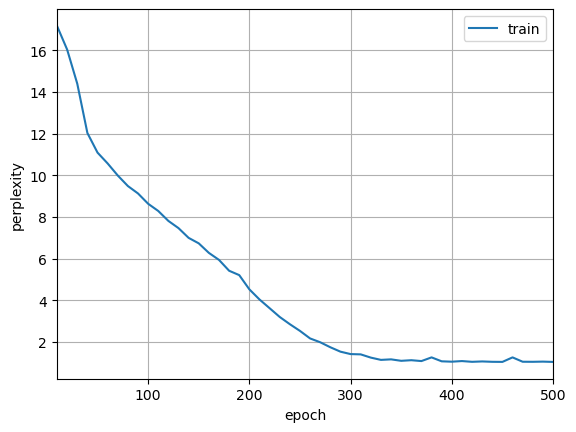

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

## Exercises

1. 调整和分析超参数对运行时间、困惑度和输出顺序的影响

2. 如何更改模型以生成适当的单词，而不是字符序列？

3. 在给定隐藏层维度的情况下，比较门控循环单元、长短期记忆网络和常规循环神经网络的计算成本。要特别注意训练和推断成本

4. 既然候选记忆元通过使用$tanh$函数来确保值范围在$(-1, 1)$
之间，那么为什么隐状态需要再次使用$tanh$函数来确保输出值范围在$(-1, 1)$之间呢？

5. 实现一个能够基于时间序列进行预测而不是基于字符序列进行预测的长短期记忆网络模型